In [151]:
from importlib import reload

from iowa_forecast import plots
from iowa_forecast import load_data
from iowa_forecast import ml_eval

reload(load_data)
reload(ml_eval)

<module 'iowa_forecast.ml_eval' from '/Users/erikingwersen/Desktop/bunge/iowa_forecast/ml_eval.py'>

In [152]:
from __future__ import annotations

import pandas as pd

import google
from google.cloud.bigquery import Client

import seaborn as sns

from rich.progress import track
from iowa_forecast.ml_train import create_models_for_items
from iowa_forecast.load_data import get_training_data, create_future_data_query
from iowa_forecast.plots import plot_historical_and_forecast
from iowa_forecast.ml_eval import evaluate_models, multi_evaluate_predictions, explain_model, get_future_sales_query, evaluate_predictions, get_predictions

In [110]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [111]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
sns.set_theme()

In [59]:
PROJECT_ID = "ee-ingwersen"
client = Client()

END_DATE = pd.Timestamp.today() - pd.DateOffset(days=14)
START_DATE = END_DATE - pd.DateOffset(years=3)

TEST_START_DATE = END_DATE + pd.DateOffset(days=1)

END_DATE = END_DATE.strftime("%Y-%m-%d")
START_DATE = START_DATE.strftime("%Y-%m-%d")
TEST_START_DATE = TEST_START_DATE.strftime("%Y-%m-%d")

In [112]:
df_train = get_training_data(client, start_date=START_DATE, end_date=END_DATE)

items_list = df_train.groupby("item_name")["total_amount_sold"].sum().sort_values(ascending=False).index.to_list()

df_test = get_training_data(client, start_date=TEST_START_DATE, table_name="bqmlforecast.test_data", items_list=items_list)
df_test

I0000 00:00:1723052505.675699  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


I0000 00:00:1723052517.650722  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,date,item_name,total_amount_sold,avg_bottle_price,total_volume_sold_liters,avg_bottle_cost,day_of_week,week_of_year,month,year,ma3_total_amount_sold,ma3_avg_bottle_price,ma7_total_amount_sold,ma7_avg_bottle_price,ma30_total_amount_sold,ma30_avg_bottle_price,temperature,rainfall,snowfall,lag_1_total_amount_sold,lag_7_total_amount_sold
0,2024-07-25,1800 REPOSADO,30.000,28.500,27.750,19.000,5,29,7,2024,20.670,31.000,11.430,31.140,76.100,30.030,74.150,8.580,0.000,28,19
1,2024-07-26,1800 REPOSADO,43.000,28.350,38.250,18.900,6,29,7,2024,33.670,29.200,16.860,30.510,74.570,30.050,73.500,7.280,0.000,30,5
2,2024-07-28,1800 REPOSADO,28.000,26.250,21.000,17.500,1,30,7,2024,33.670,27.700,20.290,29.870,74.600,30.050,73.150,8.090,0.000,43,4
3,2024-07-29,1800 REPOSADO,87.000,28.900,99.750,19.270,2,30,7,2024,52.670,27.830,31.570,29.610,74.970,30.010,73.800,11.420,0.000,28,8
4,2024-07-30,1800 REPOSADO,105.000,27.640,96.750,18.430,3,30,7,2024,73.330,27.600,46.430,29.160,72.730,29.920,74.620,10.650,0.000,87,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1580,2024-07-25,YUKON JACK,91.000,15.300,71.500,10.190,5,29,7,2024,58.330,15.270,49.570,14.940,40.270,15.430,74.150,8.580,0.000,55,46
1581,2024-07-26,YUKON JACK,29.000,16.690,26.000,11.130,6,29,7,2024,58.330,15.580,37.430,14.950,39.400,15.480,73.500,7.280,0.000,91,114
1582,2024-07-29,YUKON JACK,15.000,13.130,13.870,8.750,2,30,7,2024,45.000,15.040,34.140,15.040,38.100,15.380,73.800,11.420,0.000,29,38
1583,2024-07-30,YUKON JACK,9.000,14.820,7.750,9.880,3,30,7,2024,17.670,14.880,33.290,14.900,35.900,15.340,74.620,10.650,0.000,15,15


## Train Sales Forecasting Models

The function `create_models_for_items` trains a multivariate ARIMA model for each `'item_name'` specified in the `items_list` parameter.
By default the models are saved as `'bqmlforecast.arima_plus_xreg_model_<NAME OF THE ITEM>'`. For example: `bqmlforecast.arima_plus_xreg_model_black_velvet`.

In [ ]:
columns = ["avg_bottle_price", "avg_bottle_cost", "total_volume_sold_liters"]

In [ ]:
train_arima_models(client, columns)

In [134]:
create_future_tables(client, columns, horizon=30)

Output()

In [161]:
create_future_data_query(client, horizon=30)

I0000 00:00:1723057855.706249  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [113]:
create_models_for_items(client, items_list, max_items=4, clean_spikes_and_dips=True)

Output()

In [164]:
eval_df = evaluate_models(client, items_list[:4])
eval_df

Output()

I0000 00:00:1723058694.211335  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058697.480951  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058701.660807  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058710.108274  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058713.500243  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,item_name,symmetric_mean_absolute_percentage_error,mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error,mean_absolute_error
0,FIREBALL CINNAMON WHISKEY,12.741,11.894,1241.944,1542425.457,1095.015
0,TITOS HANDMADE VODKA,5.501,5.681,320.045,102428.930,250.634
0,BLACK VELVET,10.536,9.824,243.268,59179.434,209.895
0,HAWKEYE VODKA,5.317,5.463,105.330,11094.496,86.208


Output()

I0000 00:00:1723058724.597026  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058728.096412  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058732.195105  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058735.443391  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058738.843075  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058742.656487  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058745.979139  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported
I0000 00:00:1723058750.222219  512714 check_gcp_

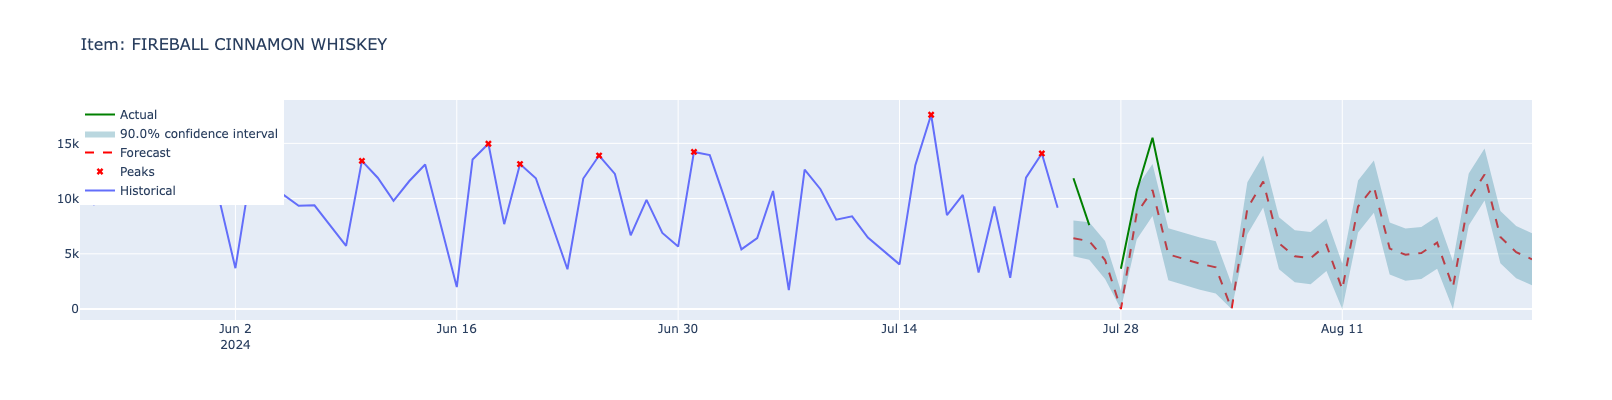

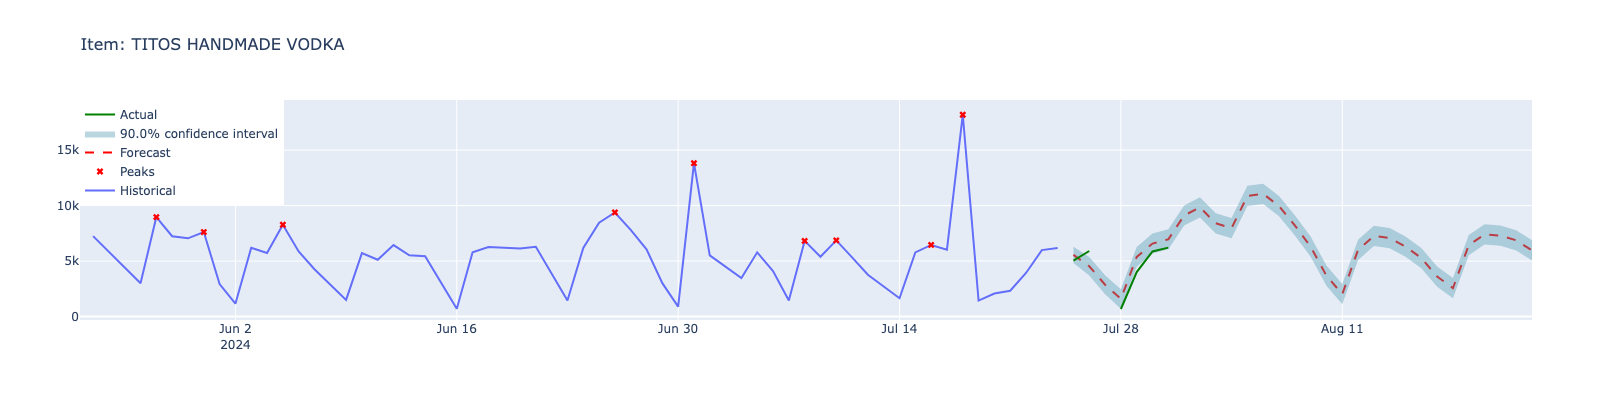

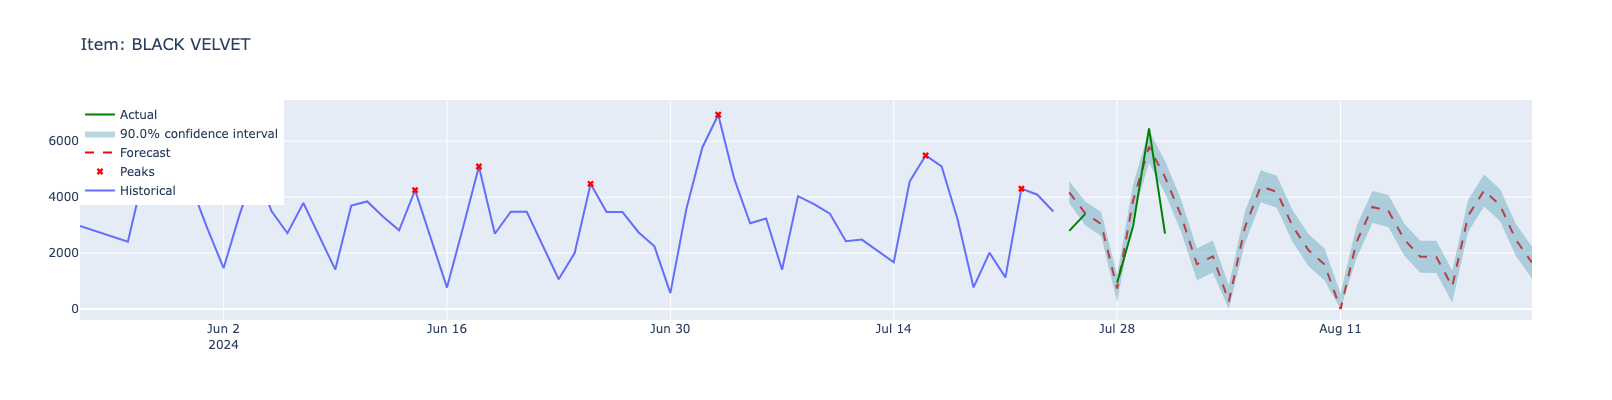

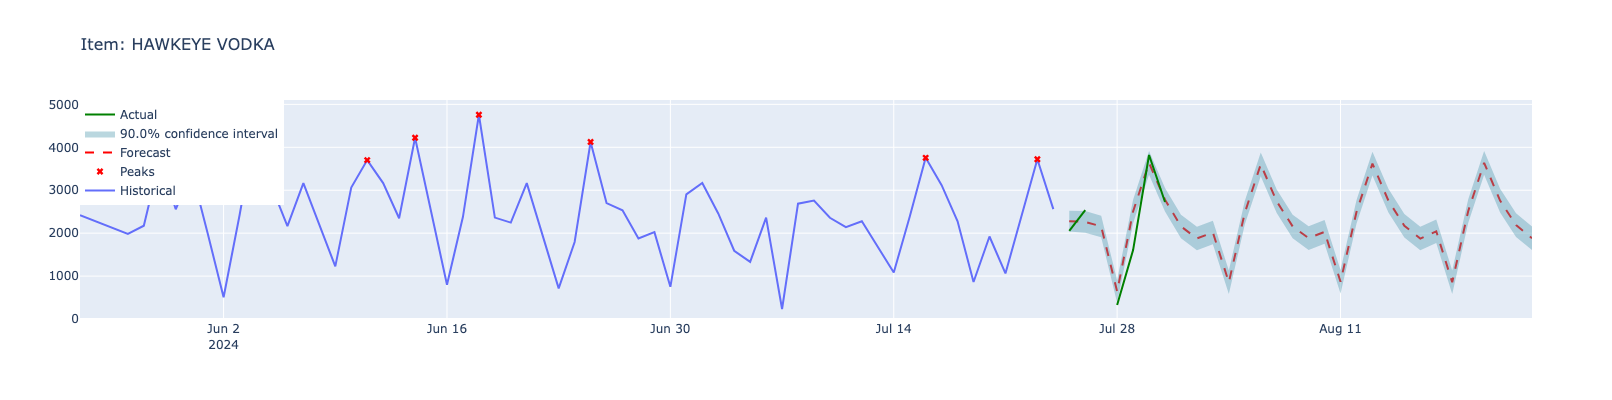

In [165]:
preds_dict  = multi_evaluate_predictions(client, items_list[:4], confidence_level=0.9, horizon=30)

for item_name, preds_info in preds_dict.items():
    actual_df = preds_info["train_df"].sort_values("date")
    predictions_df = preds_info["eval_df"].sort_values("date")

    plot_historical_and_forecast(
        input_timeseries=actual_df,
        timestamp_col_name="date",
        data_col_name="total_amount_sold",
        forecast_output=predictions_df,
        actual=predictions_df,
        title=f"Item: {item_name}",
        plotstartdate=(pd.to_datetime(END_DATE) - pd.DateOffset(months=2)).strftime("%Y-%m-%d"),
        prop={'size': 12},
        engine="plotly",
    )

In [166]:
explain_df = explain_model(client, item_name=items_list[0])
explain_df

I0000 00:00:1723058786.086481  512714 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


,time_series_timestamp,time_series_type,time_series_data,time_series_adjusted_data,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,trend,seasonal_period_yearly,seasonal_period_quarterly,seasonal_period_monthly,seasonal_period_weekly,seasonal_period_daily,holiday_effect,spikes_and_dips,step_changes,residual,holiday_effect_EasterMonday,holiday_effect_Halloween,holiday_effect_MardiGras,holiday_effect_StPatrickDay,holiday_effect_US_ColumbusDay,holiday_effect_US_ElectionDay,holiday_effect_US_IndependenceDay,holiday_effect_US_Juneteenth,holiday_effect_US_LaborDay,holiday_effect_US_MemorialDay,holiday_effect_US_MLKDay,holiday_effect_US_PresidentDay,holiday_effect_US_Superbowl,holiday_effect_VeteranDay,holiday_effect_Christmas,holiday_effect_MothersDay,holiday_effect_NewYear,holiday_effect_US_DaylightSavingEnd,holiday_effect_US_DaylightSavingStart,holiday_effect_US_Thanksgiving,holiday_effect_Valentine,attribution_item_name,attribution_avg_bottle_price,attribution_total_volume_sold_liters,attribution_avg_bottle_cost,attribution_day_of_week,attribution_week_of_year,attribution_month,attribution_year,attribution_ma3_total_amount_sold,attribution_ma3_avg_bottle_price,attribution_ma7_total_amount_sold,attribution_ma7_avg_bottle_price,attribution_ma30_total_amount_sold,attribution_ma30_avg_bottle_price,attribution_temperature,attribution_rainfall,attribution_snowfall,attribution_lag_1_total_amount_sold,attribution_lag_7_total_amount_sold,attribution___INTERCEPT__,item_name
0,2021-07-26 00:00:00+00:00,history,7926.000,7926.000,985.679,NaN,NaN,NaN,0.000,-902.498,NaN,NaN,74.696,NaN,0.000,NaN,NaN,128219.521,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5362.799,4355.729,-7729.337,279.216,-329.566,-5833.288,-20981805.066,5273.932,-1600.395,1499.453,1773.509,-1526.533,1014.958,262.241,-60.957,0.000,-2201.298,-91.850,20861890.734,FIREBALL CINNAMON WHISKEY
1,2021-07-27 00:00:00+00:00,history,11604.000,12249.551,985.679,NaN,NaN,NaN,128248.692,-695.039,NaN,NaN,1130.011,NaN,0.000,NaN,NaN,-645.551,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6227.156,6148.600,-8985.696,418.824,-329.566,-5833.288,-20981805.066,5543.486,-1665.110,1804.152,1960.418,-1527.741,1014.958,263.118,-73.411,0.000,-1484.893,-0.788,20861890.734,FIREBALL CINNAMON WHISKEY
2,2021-07-28 00:00:00+00:00,history,9014.000,8133.156,985.679,NaN,NaN,NaN,127792.979,-161.869,NaN,NaN,-743.573,NaN,0.000,NaN,NaN,880.844,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5653.021,4557.189,-8152.675,558.432,-329.566,-5833.288,-20981805.066,5058.608,-1593.398,1859.700,1956.170,-1510.969,1016.034,267.571,-116.180,0.000,-2173.946,-56.753,20861890.734,FIREBALL CINNAMON WHISKEY
3,2021-07-29 00:00:00+00:00,history,9223.000,10558.416,985.679,NaN,NaN,NaN,128703.571,-946.887,NaN,NaN,-831.460,NaN,0.000,NaN,NaN,-1335.416,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6353.340,6516.357,-9163.225,698.040,-329.566,-5833.288,-20981805.066,5288.463,-1684.350,1828.061,2000.773,-1520.200,1017.111,266.239,-116.016,0.000,-1688.724,-85.491,20861890.734,FIREBALL CINNAMON WHISKEY
4,2021-07-30 00:00:00+00:00,history,13095.000,11792.058,985.679,NaN,NaN,NaN,127420.748,-566.581,NaN,NaN,245.619,NaN,0.000,NaN,NaN,1302.942,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5627.785,6835.439,-8125.363,837.648,-329.566,-5833.288,-20981805.066,5552.700,-1630.129,1924.754,1981.657,-1544.984,1016.034,258.069,-158.784,0.000,-1727.879,-77.490,20861890.734,FIREBALL CINNAMON WHISKEY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,